<a href="https://colab.research.google.com/github/SeraphDev6/BigMart-Sales-Predictions/blob/main/BigMart_Sales_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigMart Sales Predictions by Wesley Giles

## Import necessary modules and data

In [41]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
drive.mount("/content/drive")

df = pd.read_csv("/content/drive/My Drive/Coding_Dojo/data_to_load/sales_predictions.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Data Cleaning

### Understand the shape of the data

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### Deal with duplicated data (if any)

In [43]:
df.duplicated().sum()

0

### Look for missing data

In [44]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### Item weight seems to be miissing quite a few values, so lets try to intercate the values

##### Here we based the intercated values on the mean of the rest if the items that share a type with

In [45]:
avg_weights_by_type = df.groupby("Item_Type")["Item_Weight"].mean()
for item_type in df["Item_Type"].unique():
  df.loc[df["Item_Type"] == item_type,["Item_Weight"]] = \
  df.loc[df["Item_Type"] == item_type,["Item_Weight"]].fillna(avg_weights_by_type[item_type])
df.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### Attempting to crossmatch Outlet_Identifier to fill in Outlet Size

In [46]:
df.groupby("Outlet_Identifier")[["Outlet_Size","Outlet_Location_Type"]].count()

,Outlet_Size,Outlet_Location_Type
Outlet_Identifier,,
OUT010,0,555
OUT013,932,932
OUT017,0,926
OUT018,928,928
OUT019,528,528
OUT027,935,935
OUT035,930,930
OUT045,0,929
OUT046,930,930


#### No such luck so we will put "Unknown" as the size, as the remaining data may hold some insight

In [47]:
df["Outlet_Size"].fillna("Unknown", inplace=True)
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Look for inconsistant data


In [48]:
df.nunique()

Item_Identifier              1559
Item_Weight                   431
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

#### Item Fat Content looks a bit high so lets take a closer look

In [49]:
df["Item_Fat_Content"].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

#### Normalizing Item Fat Content

In [50]:
df["Item_Fat_Content"].replace(["low fat","LF"],"Low Fat", inplace=True)
df["Item_Fat_Content"].replace("reg","Regular", inplace=True)
df.nunique()

Item_Identifier              1559
Item_Weight                   431
Item_Fat_Content                2
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

#### Checking Item Type just to be sure

In [51]:
df["Item_Type"].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

### Finally checking numerical data for outliers

In [52]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857890,0.066132,140.992782,1997.831867,2181.288914
std,4.232804,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.867061,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


### Everything looks good and ready for analysis

## Exploratory Plots

### There are many factors which can contribute to the sales of an object, so lets start by looking into any corellation between numerical values

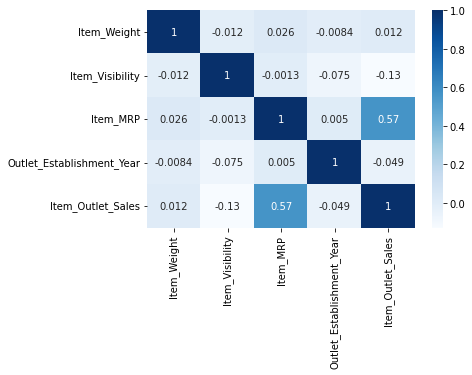

In [53]:
sns.heatmap(df.corr(),cmap="Blues",annot= True)

### This heatmap tells us there is a correlation between the Maximum Retail Price of an Item and the total revenue produced from sale of the item at an outlet, which makes logical sense, as a more expensive product provides more revenue per item sold.

### More importantly it tells us that item visibilty has a negative correlation with total revenue generated, meaning that this may be a way to predict future sales. We will explore this more with a scatter plot

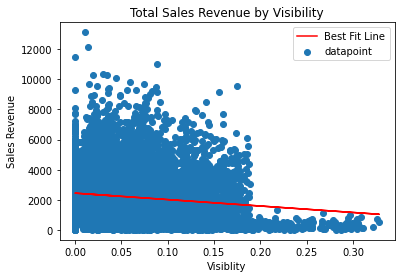

In [54]:
x = df['Item_Visibility']
y = df['Item_Outlet_Sales']

a,b = np.polyfit(x,y,1)

fig, ax = plt.subplots()

ax.scatter(x,y, label = "datapoint")
ax.plot(x,a*x+b, "r-", label="Best Fit Line")
ax.legend()
ax.set_title("Total Sales Revenue by Visibility")
ax.set_xlabel("Visiblity")
ax.set_ylabel("Sales Revenue")
plt.show()

### From the previous scatter plot we can see that there is a negative correlation between visibility and sales, with a large drop off at approximately 0.19 visibility

### Now lets look at some catgorical data. We will start with Outlet Size

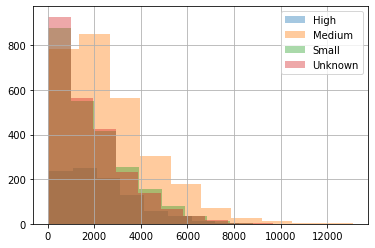

In [55]:
histogram = df.groupby("Outlet_Size")["Item_Outlet_Sales"].hist(alpha=0.4,legend=True)

### While most of the different sizes seem to fall into similar patterns, the Medium sized outlets seem to have a larger percentage of high sales items in comparison to the other sizes, We will visualize this in a different way using a boxplot

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


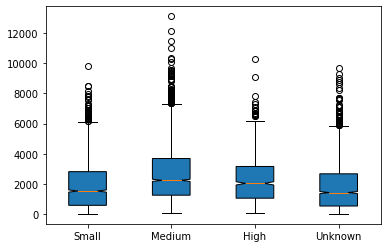

In [56]:
high = df[df["Outlet_Size"]=="High"]["Item_Outlet_Sales"]
med = df[df["Outlet_Size"]=="Medium"]["Item_Outlet_Sales"]
small = df[df["Outlet_Size"]=="Small"]["Item_Outlet_Sales"]
uk = df[df["Outlet_Size"]=="Unknown"]["Item_Outlet_Sales"]


fig, ax = plt.subplots()
bps = ax.boxplot([small, med, high, uk],labels=["Small","Medium","High","Unknown"], notch=True,
                 patch_artist=True)
plt.show()

In [57]:
df.groupby("Outlet_Size")["Item_Outlet_Sales"].describe()

,count,mean,std,min,25%,50%,75%,max
Outlet_Size,,,,,,,,
High,932.0,2298.995256,1533.531664,73.2380,1072.60380,2050.6640,3166.37835,10256.6490
Medium,2793.0,2681.603542,1855.210528,69.2432,1270.34640,2251.0698,3691.19520,13086.9648
Small,2388.0,1912.149161,1582.370364,33.9558,601.05095,1544.6560,2824.32360,9779.9362
Unknown,2410.0,1822.626947,1557.858015,33.2900,554.77785,1443.4544,2681.50950,9664.7528


### Here we are confirming our assessment that Medium sized outlets have higher average sales per item, based on the higher median, range, and outliers. 